# Transforming Healthcare with Data Analytics and AI

---

## Module 9: Machine Learning and AI

This week we learned about key concepts in machine learning and AI such as **classification vs regression**, **underfitting and overfitting**, **the bias-variance tradeoff**, **performance measures** and **algorithmic bias**. In this notebook we're going to train and assess the performance of a machine learning model that predicts failed extubation from the MIMIC-II database.

The MIMIC-II clinical database consists of data collected in a US intensive care unit and contains a large amount of information on such as **patient demographics and survival, medications, lab tests, events** and more.

The diagram below shows an example of a patient timeline with the points when different measurements are made, along with the intubation period and the period over which the means are calculated.

<center><img src="patient_timeline_intubation_241124.PNG" alt="Patient Timeline" width="60%"></center>

### Activities

There are four activities in this notebook, which you will complete during the classes

*  Activity 1: Use a Logistic Regression model to make predictions and assess model performance
*  Activity 2: Carry out cross-validation using a Random Forests Machine Learning model
*  Activity 3: Examine the performance of the model on unseen data and in particular patient cohorts to describe biases

### How to use this notebook

You are not expected to understand how all the Python code works, but should be comfortable running the code blocks

- The notebook should be read and run in sequential order and consists of blocks of code and blocks of text. 
- To run the code in a cell press `shift+enter`
- Run the cells in order. This ensures that the later cells have access to variables, functions and data that have been defined previously.

## Configure the notebook

### Import packages

In [20]:
from d2k_utils import *

In [21]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams['figure.max_open_warning'] = 100  # or any other number

%matplotlib inline
sns.set()

In [22]:
np.random.seed(42)

### Create development and test datasets

In [23]:
# load the data
df = pd.read_csv('ext_data2.csv')

# simple data transformations: get the first ICU admission for each patient
# remove patients who have died
df = (
    df
    .groupby('subject_id', as_index=False).first() # first icu admission for each patient
    .query('fail_ext_status != "Death"') # remove patients who died
    .assign(sex_coded=lambda df_: df_.sex.map({'M': 1, 'F': 0}))
    .assign(fail_ext_coded=lambda df_: df_.fail_ext_status_bin.map({'Failed extubation': 1, 
                                                                    'Successful extubation': 0}))
)

In [24]:
# total number of patients
num_patients = df.shape[0]
df_indices = np.arange(0, num_patients)

# split the data
# X contains the variables and y the labels
X_dev, X_test, y_dev, y_test = train_test_split(
    df_indices,
    df.fail_ext_coded.values,
    test_size=0.25,
    random_state=42
)

df_dev = df.iloc[X_dev, :]
df_test = df.iloc[X_test, :]

df_train = df_dev.iloc[:440, :]
df_val = df_dev.iloc[440:, :]

## Activity 1: Calculating performance statistics for logistic regression

Our goal is to develop a model to **predict which patients will experience failed extubation**. There are many possible models that can do this. 

Remember to keep in mine the type of machine learning problem we are trying to solve. In this case it is a **supervised learning problem: binary classification**. Given information about a patient who has been intubated we want to predict whether or not they will experience failed extubation

In [25]:
# select a few variables
variables = ['age', 'PaO2', 'overall_sofa_score']

# remove patients who have missing values
df_dev2 = df_dev.loc[:, variables + ['fail_ext_coded']].dropna()

# matrices for the data
# X contains the features
# y contains the outcome
X = df_dev2.loc[:, variables].values
y = df_dev2.fail_ext_coded.values

In [26]:
# define the classification algorithm to use
clf = LogisticRegression()

In [27]:
# train the model
clf.fit(X, y)

LogisticRegression()

In [28]:
# make predictions
# the labels (1 for a prediction of failed extubation and 0 for a prediction of successful extubation)
y_preds = clf.predict(X)

# the 'probabilities' for a failed extubation
y_pred_probs = clf.predict_proba(X)[:, 1]

#### 1.1. The confusion matrix

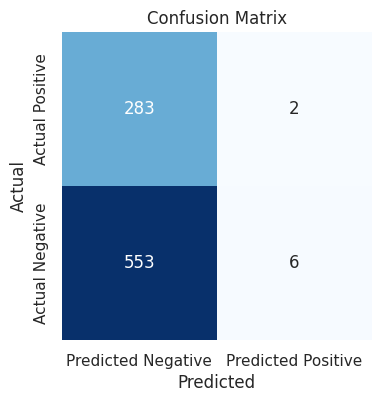

In [29]:
# calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y, y_preds).ravel()

# Create a 2x2 matrix
conf_matrix = np.array([[fn, tp],
                        [tn, fp]])

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Positive', 'Actual Negative'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**In your worksheet: complete the confusion matrix then calculate each of the following and explain what the results mean clinically:**

- Sensitivity
- Specificity
- Positive Predictive Value
- Negative Predictive Value

#### 1.2. The ROC curve and  Area Under Curve (AUC). 

The ROC curve and corresponding AUC are shown in the plot below.

**In your worksheet: How would you interpret this ROC curve and AUC?**

In [30]:
# calculate the AUC
auc = roc_auc_score(y, y_pred_probs)

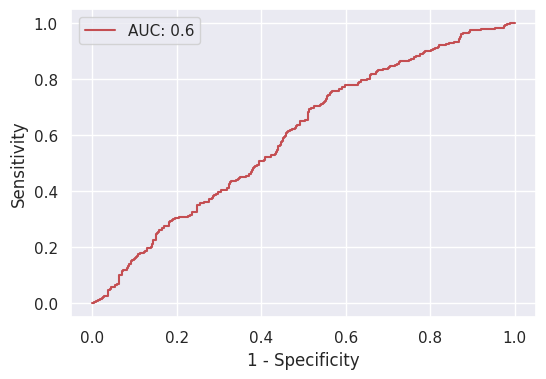

In [31]:
# calculate true positive rate and false positive rate in terms of threshold values
fpr, tpr, thresholds = roc_curve(y, y_pred_probs, pos_label=1)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC: {np.round(auc, 2)}', c='r')
plt.legend()
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.show()

## Activity 2: Cross-validation and Random Forests

### 2.1. Cross-validation 

Let's try a more sophisticated machine learning model called **Random Forests**. These models are commonly used when working with tabular data (as is the case with electronic health records). 

In [32]:
# columns to select data for
variables = ['age', 'elixhauser_score', 'hr_mean', 'rr_mean', 'FiO2_set_mean', 'FiO2_Set',
             'tidal_volume_Obs', 'arterial_bp_mean', 'Albumin (>3.2)', 'arterial_ph',
             'Creatinine (0-1.3)', 'WBC', 'respiratory_sofa_score',
             'overall_sofa_score', 'congestive_heart_failure', 'cardiac_arrhythmias',
             'valvular_disease', 'pulmonary_circulation', 'peripheral_vascular',
             'hypertension', 'paralysis', 'other_neurological', 'chronic_pulmonary',
             'diabetes_uncomplicated', 'diabetes_complicated', 'hypothyroidism',
             'renal_failure', 'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
             'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
             'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
             'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
             'drug_abuse', 'psychoses', 'depression', 'hgb',
             'PaO2', 'PaCO2']

In [33]:
X = df_dev.loc[:, variables].values
y = df_dev.fail_ext_coded.values

We will use cross-validation to train many different models using the parameters below and then select the best one.

In [34]:
# different model parameters
# similar to linear regression, RandomForests also has adjustable parameters
n_estimators = [5, 10, 50, 100]
max_depth = [1, 2, 5, 10, 20, 100]

In [35]:
mean_cv_scores = []

for n in n_estimators:
    for m in max_depth:
        clf = RandomForestClassifier(n_estimators=n, max_depth=m, random_state=0)
        scores = cross_val_score(clf, X, y, cv=10, scoring='roc_auc')
        score_mean = np.mean(scores)
        print(f"n_estimators: {n}, max_depth: {m}, mean_cv_score: {score_mean}")
        mean_cv_scores.append((n, m, score_mean))

sorted_mean_cv_score = sorted(mean_cv_scores, key=lambda x: x[2])
best = sorted_mean_cv_score[-1]

n_estimators: 5, max_depth: 1, mean_cv_score: 0.693907071887785
n_estimators: 5, max_depth: 2, mean_cv_score: 0.69540617361437
n_estimators: 5, max_depth: 5, mean_cv_score: 0.6924582101326393
n_estimators: 5, max_depth: 10, mean_cv_score: 0.6590986171771758
n_estimators: 5, max_depth: 20, mean_cv_score: 0.6374391434156845
n_estimators: 5, max_depth: 100, mean_cv_score: 0.6378679106217952
n_estimators: 10, max_depth: 1, mean_cv_score: 0.7000946857914452
n_estimators: 10, max_depth: 2, mean_cv_score: 0.7072356715313546
n_estimators: 10, max_depth: 5, mean_cv_score: 0.7046870006593097
n_estimators: 10, max_depth: 10, mean_cv_score: 0.6689558003414591
n_estimators: 10, max_depth: 20, mean_cv_score: 0.6768554240455125
n_estimators: 10, max_depth: 100, mean_cv_score: 0.6774146136416637
n_estimators: 50, max_depth: 1, mean_cv_score: 0.7276287453250915
n_estimators: 50, max_depth: 2, mean_cv_score: 0.7360250105806243
n_estimators: 50, max_depth: 5, mean_cv_score: 0.7386543317220073
n_estimator

**Worksheet: Which combination of n_estimators and max_depth gives the best mean_cv_score?**

In [36]:
# with these parameters we fit the model
clf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=0)

X_train = df_train.loc[:, variables].values
y_train = df_train.loc[:, 'fail_ext_coded'].values

X_val = df_val.loc[:, variables].values
y_val = df_val.loc[:, 'fail_ext_coded'].values

clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=0)

### 2.2. Calculating performance statistics for the model

Now we will calculate the PPV, NPV, sensitivity, specificity and AUC for this model

In [37]:
# the dataset to evaluate the performance on
dataset = df_val.loc[:, variables + ['fail_ext_coded']]

In [38]:
# calculate performance statistics
stat_names = ['PPV', 'NPV', 'sensitivity', 'specificity', 'AUC']
ppv_estims, npv_estims, sens_estims, spec_estims, auc_estims = calculate_performance_stats(dataset, clf, 32)

In [39]:
# put these in a dataframe
df_stats = (
    pd.DataFrame(data=[ppv_estims, npv_estims, sens_estims, spec_estims, auc_estims])
    .rename(columns={0: 'point_estimate', 1: 'left_ci', 2: 'right_ci'})
    .assign(stat_name=stat_names)
    .assign(dataset='validation')
)

Now let's visualise the statistics, including the point estimate of each along with the corresponding 95% confidence interval. 

**Worksheet: What do each of the performance statistics mean clinically? Which ones are most relevant for the problem (maybe more than one)?**

In [40]:
# calculate the predicted 'scores' from the model
y_pred_prob = clf.predict_proba(X_val)

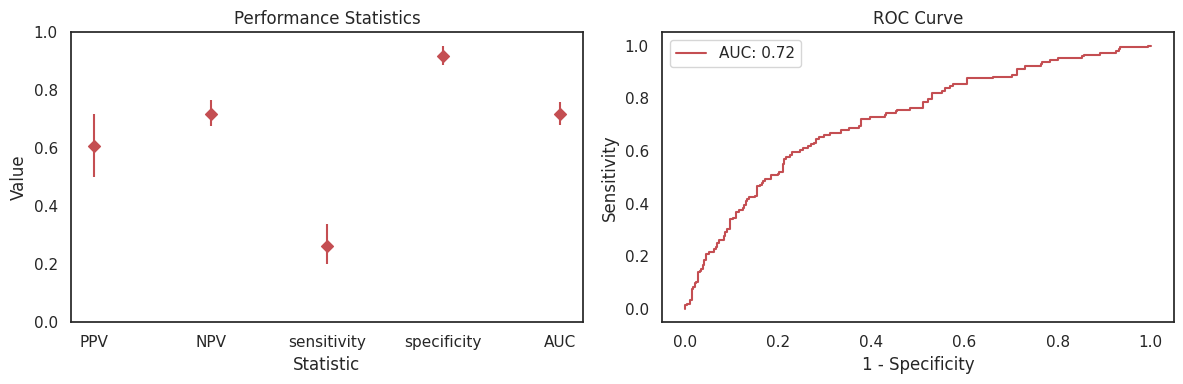

In [44]:
sns.set_style('white')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Performance Statistics
axes[0].scatter(df_stats.stat_name, df_stats.point_estimate, c='r', marker='D')
for n in range(0, 5):
    left_ci, right_ci = df_stats.loc[n, ['left_ci', 'right_ci']].values
    axes[0].vlines(n, left_ci, right_ci, colors='r')
axes[0].set_ylim(0, 1)
axes[0].set_xlabel('Statistic')
axes[0].set_ylabel('Value')
axes[0].set_title('Performance Statistics')

# Plot 2: ROC Curve
auc = roc_auc_score(y_val, y_pred_prob[:, 1])
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob[:, 1], pos_label=1)
axes[1].plot(fpr, tpr, label=f'AUC: {np.round(auc, 2)}', c='r')
axes[1].legend()
axes[1].set_xlabel("1 - Specificity")
axes[1].set_ylabel("Sensitivity")
axes[1].set_title("ROC Curve")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### 2.3. Feature importance values

Models such as Random Forests, once trained, can tell us which of the features are most important for making predictions. This can be useful for interpreting the results of the model as it allows us to compare those features identified as important with what may be expected clinically

**Worksheet: Do these 'most important' features coincide with what would be expected?**

In [22]:
# calculate the importances and the names of the features
importances = clf.feature_importances_
features = np.array(variables)

# sort them in descending order of importance
args_sorted = np.argsort(importances)
features = features[args_sorted]
importances = importances[args_sorted]

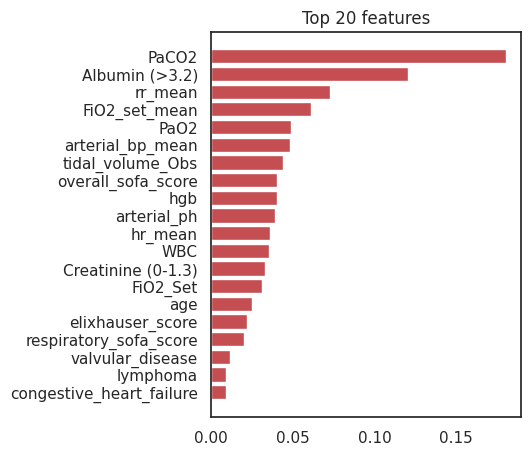

In [23]:
# plot the feature importances
plt.figure(figsize=(4, 5))
plt.barh(y=features[::-1][:20][::-1], width=importances[::-1][:20][::-1], color='r')
plt.title("Top 20 features")
plt.show()

## Activity 3: Generalisation performance and algorithmic bias

Now let's see how well the model predicts failed extubation on data that it hasn't been trained on. This is a good way to estimate how well the model would be expected to perform 'in the real world.' 

Testing the model performance on the same data as the model is trained on is one of the pitfalls of machine learning. This is a bit like rote-learning: the resulting model captures *noise* in the data rather than the true *signal*

Instead, we need to assess the performance on an independent dataset. Fortunately we have set aside 20% of the data to do this.

In [32]:
# we will now use the test set
dataset = df_test.loc[:, variables + ['fail_ext_coded']]

In [33]:
# calculate the performance statistics
ppv_estims2, npv_estims2, sens_estims2, spec_estims2, auc_estims2 = calculate_performance_stats(dataset, clf, 32)

In [34]:
# put the results from the development set and the test set in a dataframe
df_stats2 = (
    pd.DataFrame(data=[ppv_estims2, npv_estims2, sens_estims2, spec_estims2, auc_estims2])
    .rename(columns={0: 'point_estimate', 1: 'left_ci', 2: 'right_ci'})
    .assign(stat_name=stat_names)
    .assign(dataset='test')
)

df_stats_both = pd.concat(
    [
        df_stats.assign(stat_order=np.arange(0, 5)), 
        df_stats2.assign(stat_order=np.arange(0, 5) + 0.2)
    ]
)

### 3.1. Development set vs test set performance

We have kept a dataset held-out from the remaining data until the very end, so that we can get an overall estimate of how we expect the model to perform on new, unseen data from the ICU.

**Worksheet: What do you notice about the results in the visualisation below?**

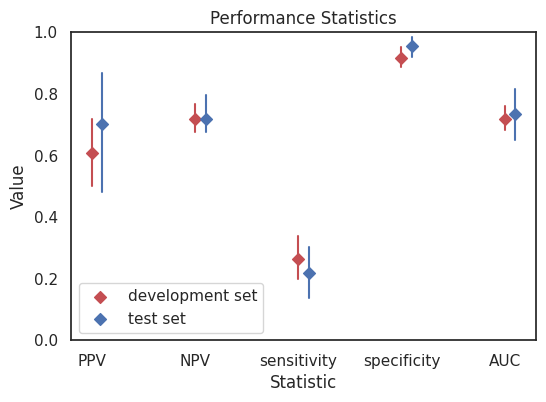

In [35]:
sns.set_style('white')

plt.figure(figsize=(6, 4))

plt.scatter(np.arange(0, 5), df_stats_both.query('dataset=="validation"').point_estimate, c='r', marker='D', label='development set')
for n in range(0, 5):
    left_ci, right_ci = df_stats_both.query('dataset=="validation"').loc[n, ['left_ci', 'right_ci']].values
    plt.axvline(n, left_ci, right_ci, c='r')

plt.scatter(np.arange(0, 5)+0.1, df_stats_both.query('dataset=="test"').point_estimate, c='b', marker='D', label='test set')
for n in range(0, 5):
    left_ci, right_ci = df_stats_both.query('dataset=="test"').loc[n, ['left_ci', 'right_ci']].values
    plt.axvline(n+0.1, left_ci, right_ci, c='b')
    
plt.ylim(0, 1)
plt.xlabel('Statistic')
plt.xticks(ticks=np.arange(0, 5), labels=stat_names)
plt.ylabel('Value')
plt.legend()
plt.title('Performance Statistics')
plt.show()

### 3.2. Algorithmic bias

We have estimated the *overall* performance of the model. But we should also consider how the model performance might vary according to different types of patients.

We will consider male and female patients. We could also define cohorts in terms of ethnicity, religion, age group or another patient characteristic. For example, if we had more than one hospital represented in the data, we might consider how the model performance varies between different hospitals.

In [28]:
# male patients
dataset_m = df_test.query('sex_coded == 1').loc[:, variables + ['fail_ext_coded']]

# female patients
dataset_f = df_test.query('sex_coded == 0').loc[:, variables + ['fail_ext_coded']]

In [29]:
# performance statistics for male and female patients
ppv_estims_m, npv_estims_m, sens_estims_m, spec_estims_m, auc_estims_m = calculate_performance_stats(dataset_m, clf, 32)
ppv_estims_f, npv_estims_f, sens_estims_f, spec_estims_f, auc_estims_f = calculate_performance_stats(dataset_f, clf, 32)

In [30]:
# dataframe for male patients
df_stats_m = (
    pd.DataFrame(data=[ppv_estims_m, npv_estims_m, sens_estims_m, spec_estims_m, auc_estims_m])
    .rename(columns={0: 'point_estimate', 1: 'left_ci', 2: 'right_ci'})
    .assign(stat_name=stat_names)
    .assign(sex='male')
    .assign(dataset='test')
)

# dataframe for female patients
df_stats_f = (
    pd.DataFrame(data=[ppv_estims_f, npv_estims_f, sens_estims_f, spec_estims_f, auc_estims_f])
    .rename(columns={0: 'point_estimate', 1: 'left_ci', 2: 'right_ci'})
    .assign(stat_name=stat_names)
    .assign(sex='female')
    .assign(dataset='test')
)

# single dataframe containing all the performance measures
df_stats_sex = pd.concat(
    [
        df_stats2.assign(stat_order=np.arange(0, 5)).assign(sex='all'),
        df_stats_m.assign(stat_order=np.arange(0, 5) + 0.1), 
        df_stats_f.assign(stat_order=np.arange(0, 5) + 0.2)
    ]
)

#### Visualise the results
A useful way to compare the results is to plot the performance statistics, including their point estimates and confidence intervals, on the same chart, showing the values for the overall cohort, only males, and only females.

**Worksheet: what do you notice about the results in the visualisation below? If there evidence for bias between men and women?**

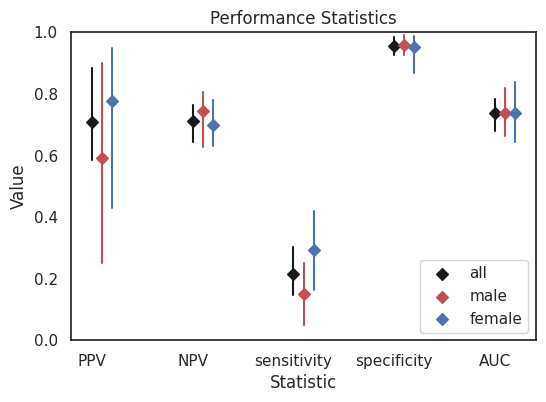

In [31]:
sns.set_style('white')

plt.figure(figsize=(6, 4))

plt.scatter(np.arange(0, 5), df_stats_sex.query('sex=="all"').point_estimate, c='k', marker='D', label='all')
for n in range(0, 5):
    left_ci, right_ci = df_stats_sex.query('sex=="all"').loc[n, ['left_ci', 'right_ci']].values
    plt.axvline(n, left_ci, right_ci, c='k')

plt.scatter(np.arange(0, 5)+0.1, df_stats_sex.query('sex=="male"').point_estimate, c='r', marker='D', label='male')
for n in range(0, 5):
    left_ci, right_ci = df_stats_sex.query('sex=="male"').loc[n, ['left_ci', 'right_ci']].values
    plt.axvline(n+0.1, left_ci, right_ci, c='r')

plt.scatter(np.arange(0, 5)+0.2, df_stats_sex.query('sex=="female"').point_estimate, c='b', marker='D', label='female')
for n in range(0, 5):
    left_ci, right_ci = df_stats_sex.query('sex=="female"').loc[n, ['left_ci', 'right_ci']].values
    plt.axvline(n+0.2, left_ci, right_ci, c='b')
    
plt.ylim(0, 1)
plt.xlabel('Statistic')
plt.xticks(ticks=np.arange(0, 5), labels=stat_names)
plt.ylabel('Value')
plt.title('Performance Statistics')
plt.legend()
plt.show()